In [2]:
#In this example, we will download the MNIST handwritten digits and create a simple CNN network to predict the digit category (0-9).
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [3]:
sess = tf.Session()

In [4]:
#Load data
data_dir = 'temp'#目录名字
mnist = read_data_sets(data_dir)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting temp/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting temp/train-labels-idx1-ubyte.gz
Extracting temp/t10k-images-idx3-ubyte.gz
Extracting temp/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [6]:
#Convert images into 28*28 (they are downloaded as 1*784)
train_xdata = np.array([np.reshape(x, (28, 28)) for x in mnist.train.images])
test_xdata = np.array([np.reshape(x, (28, 28)) for x in mnist.test.images])

#Convert labels into one-hot encoded vectors
train_labels = mnist.train.labels
test_labels = mnist.test.labels
print(mnist.train.labels)
print(train_labels)
print(mnist.test.labels)
print(test_labels)

[7 3 4 ... 5 6 8]
[7 3 4 ... 5 6 8]
[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]


In [59]:
#Set model parameters
batch_size = 100
learning_rate = 0.005
evaluation_size = 500
#评价用的size
image_width = train_xdata[0].shape[0]
image_height = train_xdata[0].shape[1]
target_size = max(train_labels) + 1
#？
num_channels = 1#greyscale = 1 channel
generations = 500
eval_every = 5
conv1_features = 25
conv2_features = 50
max_pool_size1 = 2 #NxN window for 1st max pool layer
max_pool_size2 = 2 #NxN window for 2nd max pool layer
fully_connected_size1 = 100


In [60]:
#Declare model placeholders. Remember that we need placeholders for the training data and the evaluation data
x_input_shape = (batch_size, image_width, image_height, num_channels)
x_input = tf.placeholder(tf.float32, shape = x_input_shape)
y_target = tf.placeholder(tf.int32, shape=(batch_size))

eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
eval_input = tf.placeholder(tf.float32, shape = eval_input_shape)
eval_target = tf.placeholder(tf.int32, shape = (evaluation_size))



In [61]:
#Here we declare model parameters. For this model we will have two convolutional layers (each having filter size 4x4). We follow this with two fully connected layers.
# Convolutional layer variables
conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features], stddev = 0.1, dtype = tf.float32))
conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype = tf.float32))
conv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, conv2_features], stddev = 0.1, dtype = tf.float32))
conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype = tf.float32))

#fully connected variables
resulting_width = image_width // (max_pool_size1 * max_pool_size2)
resulting_height = image_height // (max_pool_size1 * max_pool_size2)
full1_input_size = resulting_width * resulting_height * conv2_features
full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1], stddev = 0.1, dtype = tf.float32))
full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev = 0.1, dtype = tf.float32))
full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev = 0.1, dtype = tf.float32 ))
full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, target_size], stddev = 0.1, dtype = tf.float32))

In [63]:
# Initialize Model Operations
def my_conv_net (input_data):
    #First Conv-Relu-Maxpool Layer
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides = [1, 1, 1, 1], padding = 'SAME')
    #https://blog.csdn.net/mao_xiao_feng/article/details/53444333   tf.nn.conv2d
    #https://www.jianshu.com/p/05c4f1621c7e   difference between 'SAME' and 'VALID'
    #input_data:(100,28,28,1) conv1_weight:(4,4,1,25)
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    #relu1:(100,28,28,25) conv1:(100,28,28,25)
    max_pool1 = tf.nn.max_pool(relu1, ksize = [1, max_pool_size1, max_pool_size1, 1], padding = 'SAME',strides = [1, max_pool_size1, max_pool_size1, 1])
    #max_pool1:(100,14,14,25)
    #https://blog.csdn.net/mao_xiao_feng/article/details/53453926
    
    #Second Conv-ReLU-Maxpool Layer
    conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides = [1, 1, 1, 1], padding = 'SAME')
    #conv2:(100,14,14,50) relu2:(100,14,14,50)
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize = [1, max_pool_size2, max_pool_size2, 1],strides = [1, max_pool_size2, max_pool_size2, 1], padding = 'SAME')
    #max_pool2:(100,7,7,50)
    
    #Transform Output into a 1*N layer for next fully connected layer
    final_conv_shape = max_pool2.get_shape().as_list()
    #(100,7,7,50)
    final_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3]
    flat_output = tf.reshape(max_pool2, [final_conv_shape[0], final_shape])
    #(100,2450)
    
    #First Fully Connected Layer
    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))
    #(100,100)
    
    #Second Fully Connected Layer
    final_model_output = tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias)
    #(100,10)
    
    return(final_model_output)

model_output = my_conv_net(x_input)
test_model_output = my_conv_net(eval_input)


In [64]:
#Declare Loss Function(softmax cross entropy)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = model_output, labels = y_target))


In [65]:
#Create a prediction function
prediction = tf.nn.softmax(model_output)
test_prediction = tf.nn.softmax(test_model_output)

#Create accuracy function
def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis = 1)
    num_correct = np.sum(np.equal(batch_predictions, targets))
    return(100. * num_correct/batch_predictions.shape[0])


In [66]:
#Create an optimizer
my_optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
train_step = my_optimizer.minimize(loss)

#Initialize Variables 
init = tf.global_variables_initializer()
sess.run(init)

In [67]:
#Start training loop
train_loss = []
train_acc = []
test_acc = []
for i in range(generations):
    rand_index = np.random.choice(len(train_xdata), size = batch_size)
    rand_x = train_xdata[rand_index]
    rand_x = np.expand_dims(rand_x, 3)
    rand_y = train_labels[rand_index]
    train_dict = {x_input: rand_x, y_target: rand_y}
    
    sess.run(train_step, feed_dict = train_dict)
    temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict = train_dict)
    temp_train_acc = get_accuracy(temp_train_preds, rand_y)
    
    if(i + 1) % eval_every == 0:
        eval_index = np.random.choice(len(test_xdata), size = evaluation_size)
        eval_x = test_xdata[eval_index]
        eval_x = np.expand_dims(eval_x, 3)
        eval_y = test_labels[eval_index]
        test_dict = {eval_input: eval_x, eval_target:eval_y}
        test_preds = sess.run(test_prediction, feed_dict = test_dict)
        temp_test_acc = get_accuracy(test_preds, eval_y)
        
        #Record and print results
        train_loss.append(temp_train_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)
        acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
        acc_and_loss = [np.round(x, 2) for x in acc_and_loss]
        print('Generation # {}. Train Loss: {:.2f}. train ACC (Test Acc): {:.2f}'.format(*acc_and_loss))
        

Generation # 5. Train Loss: 2.30. train ACC (Test Acc): 11.00
Generation # 10. Train Loss: 2.19. train ACC (Test Acc): 26.00
Generation # 15. Train Loss: 2.12. train ACC (Test Acc): 32.00
Generation # 20. Train Loss: 1.98. train ACC (Test Acc): 41.00
Generation # 25. Train Loss: 1.82. train ACC (Test Acc): 61.00
Generation # 30. Train Loss: 1.72. train ACC (Test Acc): 56.00
Generation # 35. Train Loss: 1.40. train ACC (Test Acc): 76.00
Generation # 40. Train Loss: 1.30. train ACC (Test Acc): 64.00
Generation # 45. Train Loss: 0.96. train ACC (Test Acc): 76.00
Generation # 50. Train Loss: 0.63. train ACC (Test Acc): 80.00
Generation # 55. Train Loss: 0.61. train ACC (Test Acc): 81.00
Generation # 60. Train Loss: 0.58. train ACC (Test Acc): 78.00
Generation # 65. Train Loss: 0.54. train ACC (Test Acc): 80.00
Generation # 70. Train Loss: 0.50. train ACC (Test Acc): 86.00
Generation # 75. Train Loss: 0.44. train ACC (Test Acc): 87.00
Generation # 80. Train Loss: 0.54. train ACC (Test Acc):

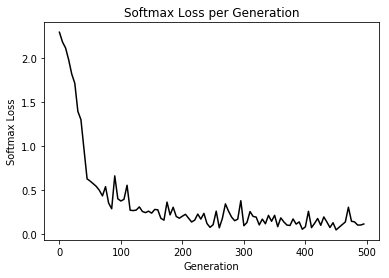

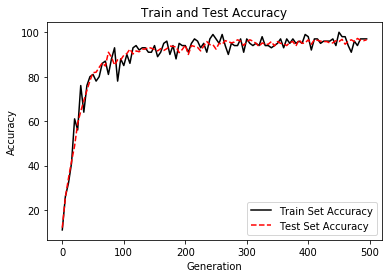

In [68]:
#Matplotlib code to plot the loss and accuracies
eval_indices = range(0, generations, eval_every)
#plot loss over time
plt.plot(eval_indices, train_loss, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()

#plot train and test accuracy
plt.plot(eval_indices, train_acc, 'k-', label = 'Train Set Accuracy')
plt.plot(eval_indices, test_acc, 'r--', label = 'Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()